In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import datetime
import random
import pandas as pd

from IPython import display
from gan.gan_dataset import get_gan_dataset
from gan.gan_models import make_discriminator_model
from src.generators import *
from src.models import *
from src.losses import *

batch_size = 12

gan_size = 64
gan_depth = 1
gan_train_frac = 0.8
gan_val_frac = 0.1

src_window_size = 2
src_sample_size = 12
src_tile_size = 64
src_seed_size = 100

epochs = 50


src_data_dir = "training_data"


src_train_ids = np.load(src_data_dir + '/train_ids.npy')
src_val_ids = np.load(src_data_dir + '/val_ids.npy')
mean, std, src_train_dataset = get_src_dataset(src_data_dir, src_train_ids, src_window_size, batch_size = batch_size)
mean, std, src_val_dataset = get_src_dataset(src_data_dir, src_val_ids, src_window_size, batch_size = batch_size)


2023-08-02 20:54:19.180723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 20:54:19.313222: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-02 20:54:22.517423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-02 20:54:22.581208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA no

In [3]:
!pip install pykrige

  Using cached PyKrige-1.7.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (860 kB)


In [4]:
from evaluate_models import *

In [5]:
#Slide 5: Full, cloud, and masked
from pathlib import Path

In [ ]:
full_pg = list(Path(src_data_dir + '/full_data').glob('*.npy'))
cloud_pg = list(Path(src_data_dir + '/cloud_data').glob('*.npy'))
masked_pg = list(Path(src_data_dir + '/masked_data').glob('*.npy'))

In [4]:
ids = np.load(src_data_dir + '/train_ids.npy')

In [6]:
print(ids[0])

[  0. 168.   0.]


In [7]:
suffix = '/tile{tileNum}_block{blockNum}.npy'

In [33]:
ind = 200

In [34]:
full = np.load(src_data_dir + '/full_data/' + suffix.format(tileNum=int(ids[ind][0]), blockNum=int(ids[ind][1])))
cloud = np.load(src_data_dir + '/cloud_data/' + suffix.format(tileNum=int(ids[ind][0]), blockNum=int(ids[ind][1])))
masked = np.load(src_data_dir + '/masked_data' + suffix.format(tileNum=int(ids[ind][0]), blockNum=int(ids[ind][1])))

In [37]:
print(np.isnan(full).sum() == np.isnan(masked).sum())

True


In [ ]:
print(np.isnan(full).sum(), np.isnan(masked).sum())

In [46]:
print(np.isnan(masked[0]).sum())

4096


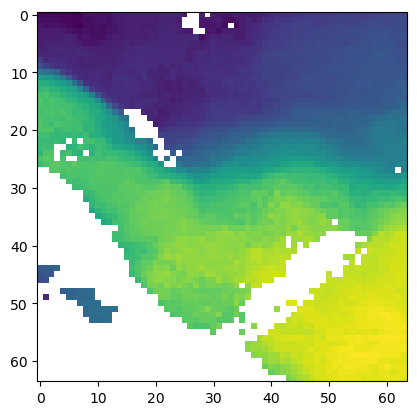

In [54]:
plt.imshow(full[0, :, :])

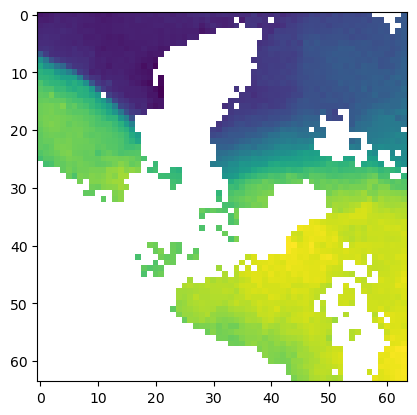

In [57]:
plt.imshow(full[3, :, :])

In [64]:
sample_cloud = np.isnan(full[3, :, :])

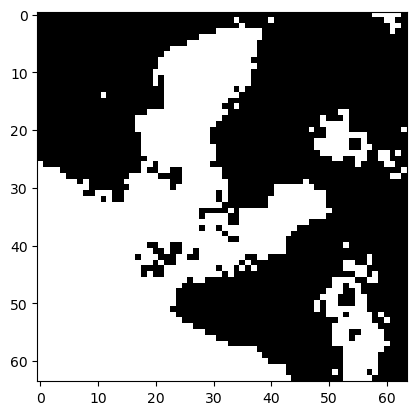

In [65]:
plt.imshow(sample_cloud, cmap='gray')

In [66]:
original = full[0, :, :]

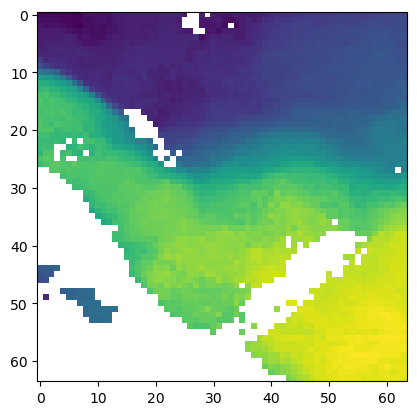

In [67]:
plt.imshow(original)

In [68]:
original[sample_cloud] = np.nan

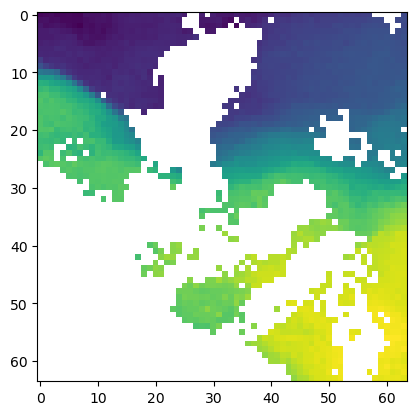

In [69]:
plt.imshow(original)

In [12]:
cloud = np.load(src_data_dir + '/cloud_data/' + suffix.format(tileNum=int(ids[0][0]), blockNum=int(ids[0][1])))

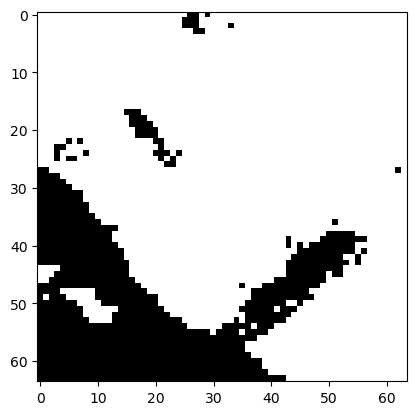

In [56]:
plt.imshow(cloud[0, :, :], cmap='gray')

In [15]:
masked = np.load(src_data_dir + '/masked_data' + suffix.format(tileNum=int(ids[0][0]), blockNum=int(ids[0][1])))

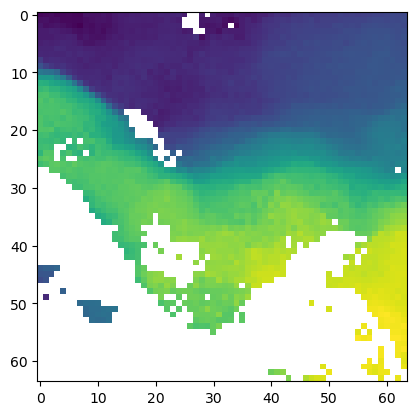

In [55]:
plt.imshow(masked[0, :, :])

In [ ]:
#Slide 7: Kriging example

In [24]:
!pip install pykrige

  Using cached PyKrige-1.7.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (860 kB)


In [25]:
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D

In [3]:
for batch in src_val_dataset:
    sample_batch = batch
    break

In [125]:
def show_baseline(batch_x, batch_y, ind):
    x = batch_x[ind, :, :, :]
    y = batch_y[ind, :, :, :]

    locs = np.where(x != 0)

    gridx = np.arange(0.0, x.shape[1])
    gridy = np.arange(0.0, x.shape[2])
    gridz = np.arange(0.0, x.shape[0])
    arr = np.zeros((len(locs[0]), 4))

    data_arr = x[locs[0], locs[1], locs[2]]

    arr[:, 0] = locs[2]
    arr[:, 1] = locs[1]
    arr[:, 2] = locs[0]
    arr[:, 3] = data_arr
    uk3d = UniversalKriging3D(
        arr[:1000, 0], arr[:1000, 1], arr[:1000, 2], arr[:1000, 3], variogram_model="linear", verbose=True
    )
    print("Done")
    vals, ss3d = uk3d.execute("grid", gridx, gridy, gridz)
    return vals

In [8]:
def baseline_predict(tf_input):
    
    np_input = tf_input.numpy()
    
    locs = np.where(np_input != 0)
    
    gridx = np.arange(0.0, np_input.shape[1])
    gridy = np.arange(0.0, np_input.shape[2])
    gridz = np.arange(0.0, np_input.shape[0])
    arr = np.zeros((len(locs[0]), 4))

    data_arr = np_input[locs[0], locs[1], locs[2]]

    arr[:, 0] = locs[2]
    arr[:, 1] = locs[1]
    arr[:, 2] = locs[0]
    arr[:, 3] = data_arr
    uk3d = UniversalKriging3D(
        arr[:1000, 0], arr[:1000, 1], arr[:1000, 2], arr[:1000, 3], variogram_model="linear", verbose=True
    )
    print("Done")
    vals, ss3d = uk3d.execute("grid", gridx, gridy, gridz)
    return tf.convert_to_tensor(vals)
    
    

In [9]:
def unseeded_model_predict(tf_input, model):
    return model(tf_input, training=False)

def seeded_model_predict(tf_input, model, src_seed_size):
    noise = tf.random.normal([tf_input.shape[0], src_seed_size])
    return model([tf_input, noise], training=False)

In [10]:
def all_predicts(tf_batch, models = []):
    
    
    tf_x, tf_y = tf_batch
    
    tf_pred_baseline = tf.reshape(baseline_predict(tf_x), tf_y.shape)
    tf_pred_models = []
    for model in models:
        tf_pred_models.append(tf.reshape(unseeded_model_predict(tf_x, model), tf_y.shape))
    
    return tf_x, tf_y, tf_pred_baseline, tf_pred_models
    
    
def all_predicts_np(tf_batch, models = []):
    
    tf_x, tf_y, tf_pred_baseline, tf_pred_models = all_predicts(tf_batch, models)
    
    np_x = tf_x.numpy()
    np_y = tf_y.numpy()
    np_pred_baseline = tf_pred_baseline.numpy()
    np_pred_models = [pred.numpy() for pred in tf_pred_models]
    
    return np_x, np_y, np_pred_baseline, np_pred_models
    
    

In [ ]:
def 

In [ ]:
def np_mse_loss(np_true, np_pred):
    valid = (~np.isnan(np_true))
    num_valid = np.sum(valid)
    return np.sum(np.square(np_true[valid] - np_pred[valid])) / num_valid
    

def show_hour(tf_batch, models = [], ind, hour):
    np_x, np_y, np_pred_baseline, np_pred_models = all_predicts_np(tf_batch, model)
    
    vmin = np.nanmin(np_y[ind, :, :, :])
    vmax = np.nanmax(np_y[ind, :, :, :])
        
    np_x = np_x[ind, hour, :, :]
    np_y = np_y[ind, hour, :, :]
    np_pred_baseline = np_pred_baseline[ind, hour, :, :]
    np_pred_models = [np_pred_model[ind, hour, :, :] for np_pred_model in np_pred_models]
    
    np_x[np_x == 0] = np.nan
    
    baseline_loss = np_mse_loss(np_y, np_pred_baseline)
    models_loss = [np_mse_loss(np_y, np_model) for np_model in np_pred_models]
    
    fig, axs = plt.subplots(1, len(models) + 3)
    
    axs[0].imshow(np_x, vmin=vmin, vmax=vmax)
    axs[0].set_title(f"X, Ind {ind} Hour {hour}")
    axs[1].imshow(np_y, vmin=vmin, vmax=vmax)
    axs[1].set_title(f"Y, Ind {ind} Hour {hour}")
    
    axs[2].imshow(np_pred_baseline, vmin=vmin, vmax=vmax)
    axs[2].set_title(f"Baseline, Loss {baseline_loss}")
    
    for i in range(len(models)):
        axs[i+3].imshow(np_pred_models[i], vmin=vmin, vmax=vmax)
        axs[i+3].set_title(f"Model {i}, Loss {models_loss[i]}")
    

In [7]:
batch_x, batch_y = sample_batch

In [7]:
pd.read_csv('experiments/gan_experiment_2023-08-02_16:13:40.661113/log.csv')

,epoch,train_gen_loss,train_disc_loss,train_gen_acc,val_gen_loss,val_disc_loss,val_gen_acc
0,1,0.244185,0.580598,0.471974,0.078501,3.779444,0.928942
1,2,0.198358,0.518132,0.473730,0.094014,5.378420,0.958590
2,3,0.181797,0.453773,0.478006,0.102259,6.957222,0.966154
3,4,0.173296,0.406212,0.481117,0.103929,8.516564,0.974247
4,5,0.168523,0.364882,0.483665,0.103854,10.003460,0.979378
5,6,0.165733,0.329271,0.485620,0.108073,11.461496,0.982815
6,7,0.164263,0.298794,0.487343,0.112535,12.689885,0.985243
7,8,0.163659,0.273212,0.488675,0.118154,13.834898,0.987047
8,9,0.163477,0.251687,0.489777,0.123326,14.982653,0.988483
9,10,0.163605,0.233283,0.490664,0.126157,15.966022,0.989628


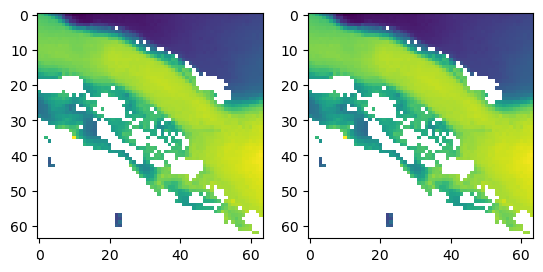

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample)
ax2.imshow(sample)

In [3]:
trained_ConvLSTM = get_trained_ConvLSTM("experiments/experiment_2023-07-27_00:33:32.478984")

In [6]:
model_2 = create_ConvLSTM(n_t = 12, tile_size = 64)
model_2.load_weights('weights/convlstm_sst_attempt_2023-07-17 14:59:27.218455.h5')

In [5]:
gan_model_1 = get_trained_ConvLSTM_Seeded('experiments/gan_experiment_2023-07-27_02:35:26.303915')

In [ ]:
trained_GAN_ConvLSTM_1 = get_trained_ConvLSTM_Seeded('experiments/gan_experiment_2023-07-27_02:35:26.303915')
trained_GAN_ConvLSTM_2 = 

In [128]:
def show(batch, batch_ind, hour):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
    batch_x, batch_y = batch
    batch_x_np = batch_x.numpy()
    
    batch_y_np = batch_y.numpy()
    vmin = np.nanmin(batch_y_np[batch_ind, hour, :, :])
    vmax = np.nanmax(batch_y_np[batch_ind, hour, :, :])
    
    sample_x = batch_x_np[batch_ind, hour, :, :]
    sample_x[sample_x == 0] = np.nan
    sample_y = batch_y_np[batch_ind, hour, :, :]
    print(sample_x)
    ax1.imshow(sample_x, vmin=vmin, vmax=vmax)
    
    ax1.set_title("X")
    ax2.imshow(sample_y, vmin=vmin, vmax=vmax)
    print(sample_y)
    ax2.set_title("Y")
    
    baseline = show_baseline(batch_x_np, batch_y_np, batch_ind)
    baseline = baseline[hour, :, :]
    print(baseline)
    ax3.imshow(baseline, vmin=vmin, vmax=vmax)
    ax3.set_title("Predicted Y (Kriging)")
    
    print(batch_x.shape)
    
    x = tf.reshape(batch_x[batch_ind, :, :, :], (1, batch_x.shape[1], batch_x.shape[2], batch_x.shape[3], 1))
    y = batch_y[batch_ind, :, :, :]

    noise = tf.random.normal([x.shape[0], 100])
    pred_outputs = tf.reshape(gan_model_1([x, noise], training=False), y.shape).numpy()
    to_plot = pred_outputs[hour, :, :]
    print(to_plot)
    ax4.imshow(to_plot, vmin=vmin, vmax=vmax)
    ax4.set_title("Predicted Y (GAN-ConvLSTM)")
    
    x = tf.reshape(batch_x[batch_ind, :, :, :], (1, batch_x.shape[1], batch_x.shape[2], batch_x.shape[3], 1))
    y = batch_y[batch_ind, :, :, :]
    pred_outputs = tf.reshape(model_2(x, training=False), y.shape).numpy()
    to_plot = pred_outputs[hour, :, :]
    print(to_plot)
    ax5.imshow(to_plot, vmin=vmin, vmax=vmax)
    ax5.set_title("Predicted Y (ConvLSTM)")

[[       nan        nan        nan ... -3.4671059 -3.4800944 -3.4800944]
 [       nan        nan        nan ... -3.522322  -3.528826  -3.528826 ]
 [       nan        nan        nan ... -3.4606018 -3.4606018 -3.4540975]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
[[-2.5119252 -2.5660603 -2.609382  ... -3.4671059 -3.4800944 -3.4800944]
 [-2.5184193 -2.5530784 -2.5184293 ... -3.522322  -3.528826  -3.528826 ]
 [-2.4967487 -2.5606568 -2.5617375 ... -3.4606018 -3.4606018 -3.4540975]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 0.0031679

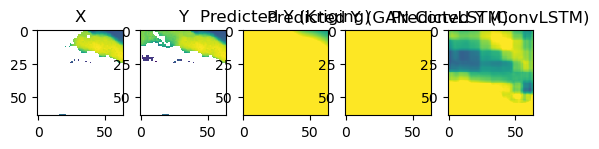

In [129]:
show(sample_batch, 1, 11)

In [17]:
for ind in range(batch_x.shape[0]):
    for hour in range(batch_x[ind].shape[0]):
        sample = batch_x[ind, hour, :, :].numpy()
        sample[sample == 0] = np.nan
        ax1.imshow(sample)
        plt.show()
        break

In [18]:
ax1.imshow(sample)

In [19]:
plt.show()

In [ ]:
#Slide 10: Discriminator example

In [ ]:
#Slide 13: Train/val loss curves for discriminator, convLSTM, gan-convLSTM

In [ ]:
#Slide 14: GIF of sample outputs on val dataset

In [ ]:
#15: Get basic final loss for each

In [ ]:
#16: Get basic time stats for each

In [6]:
evaluate_ConvLSTM(model_1, src_val_dataset)

2023-07-27 16:27:10.324648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


tf.Tensor(251478.0, shape=(), dtype=float32) tf.Tensor(338346.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(253830.0, shape=(), dtype=float32) tf.Tensor(335994.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(301561.0, shape=(), dtype=float32) tf.Tensor(288263.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(269835.0, shape=(), dtype=float32) tf.Tensor(319989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(326448.0, shape=(), dtype=float32) tf.Tensor(263376.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237584.0, shape=(), dtype=float32) tf.Tensor(352240.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237835.0, shape=(), dtype=float32) tf.Tensor(351989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(255810.0, shape=(), dtype=float32) tf.Tensor(

<tf.Tensor: shape=(), dtype=float32, numpy=1.7346925>

In [7]:
evaluate_ConvLSTM(model_2, src_val_dataset)

tf.Tensor(251478.0, shape=(), dtype=float32) tf.Tensor(338346.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(253830.0, shape=(), dtype=float32) tf.Tensor(335994.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(301561.0, shape=(), dtype=float32) tf.Tensor(288263.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(269835.0, shape=(), dtype=float32) tf.Tensor(319989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(326448.0, shape=(), dtype=float32) tf.Tensor(263376.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237584.0, shape=(), dtype=float32) tf.Tensor(352240.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(237835.0, shape=(), dtype=float32) tf.Tensor(351989.0, shape=(), dtype=float32) tf.Tensor(589824.0, shape=(), dtype=float32)
tf.Tensor(255810.0, shape=(), dtype=float32) tf.Tensor(

<tf.Tensor: shape=(), dtype=float32, numpy=0.11166117>

In [3]:
evaluate_baseline(src_val_dataset)

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 0.003551772712024482
Nugget: 2.8769884268719576e-09 

Calculating statistics on variogram model fit...
Q1 = 0.010308519576597647
Q2 = 0.35853781635295057
cR = 0.00195508451202925 

Initializing drift terms...
Done
Executing Ordinary Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 0.003551772712024482
Nugget: 2.8769884268719576e-09 

Calculating statistics on variogram model fit...
Q1 = 0.010308519576597647
Q2 = 0.35853781635295057
cR = 0.00195508451202925 

Initializing drift terms...
Done
Executing Ordinary Kriging...

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 0.003551772712024482
Nugget: 2.8769884268719576e-09 

Calculating statistics on variogram model fit...
Q1 = 0.010308519576597647
Q2 = 0.35853781635295057
cR = 0.00195508451202925 

Initializing drift t

1.0939930654833023

In [4]:
from evaluate_models import *

In [6]:
gan_model_1 = get_trained_ConvLSTM_Seeded('experiments/gan_experiment_2023-07-27_02:35:26.303915')

In [7]:
evaluate_ConvLSTM_Seeded(gan_model_1, src_val_dataset)

2023-07-27 16:31:40.633350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


tf.Tensor(14136.0, shape=(), dtype=float32) tf.Tensor(35016.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(14180.0, shape=(), dtype=float32) tf.Tensor(34972.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(14172.0, shape=(), dtype=float32) tf.Tensor(34980.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(14479.0, shape=(), dtype=float32) tf.Tensor(34673.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(14956.0, shape=(), dtype=float32) tf.Tensor(34196.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(15463.0, shape=(), dtype=float32) tf.Tensor(33689.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(21943.0, shape=(), dtype=float32) tf.Tensor(27209.0, shape=(), dtype=float32) tf.Tensor(49152.0, shape=(), dtype=float32)
tf.Tensor(24716.0, shape=(), dtype=float32) tf.Tensor(24436.0, shape=(), dty

<tf.Tensor: shape=(), dtype=float32, numpy=3.3166018>